#sparse annotation
1. maximum coverage - sample SEAM's .npy values
2. boundary coverage - sobel operator

- work with single instance images first
- expand to multiple instances images later - with overlapping and occulsion


In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter
import seaborn as sns
from PIL import Image
from io import BytesIO
from scipy import ndimage
import cv2

out_cam_path = "C:/Users/snack/Desktop/SEAM/voc12/out_cam"
output_dir = "C:/Users/snack/Desktop/CAM4SAM/temp_files"
os.makedirs(output_dir, exist_ok=True)

Processing files: 100%|██████████| 12031/12031 [00:03<00:00, 3826.06it/s]


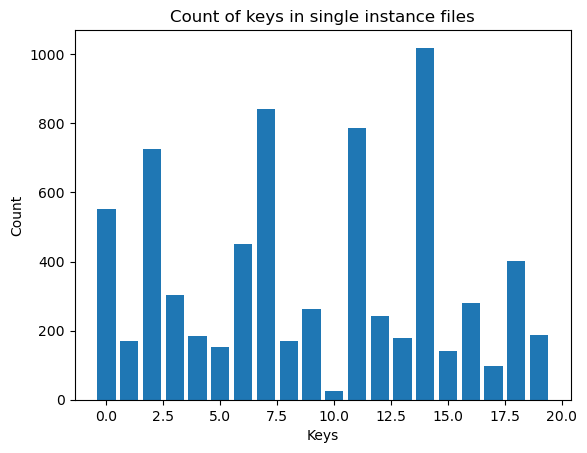

In [7]:
keys_lst = []
sample = {}
classZeroImages = []

file_list = os.listdir(out_cam_path)
npy_files = [file for file in file_list if file.endswith(".npy")]

for filename in tqdm(npy_files, desc="Processing files"):
    file_path = os.path.join(out_cam_path, filename)
    data = np.load(file_path, allow_pickle=True).item()
    
   # single instance images of class 0 (airplanes)
    if len(data.keys()) == 1:
        key = list(data.keys())[0]
        keys_lst.append(key)

        if key not in sample:
            sample[key] = filename

        if key == 0:
          classZeroImages.append(filename)

# save filename of all class 0 images
with open(os.path.join(output_dir, 'classZeroSingleInstanceImages.txt'), 'w') as file:
    for item in classZeroImages:
        file.write('%s\n' % item)

key_counts = Counter(keys_lst)

plt.bar(key_counts.keys(), key_counts.values())
plt.xlabel('Keys')
plt.ylabel('Count')
plt.title('Count of keys in single instance files')
plt.show()

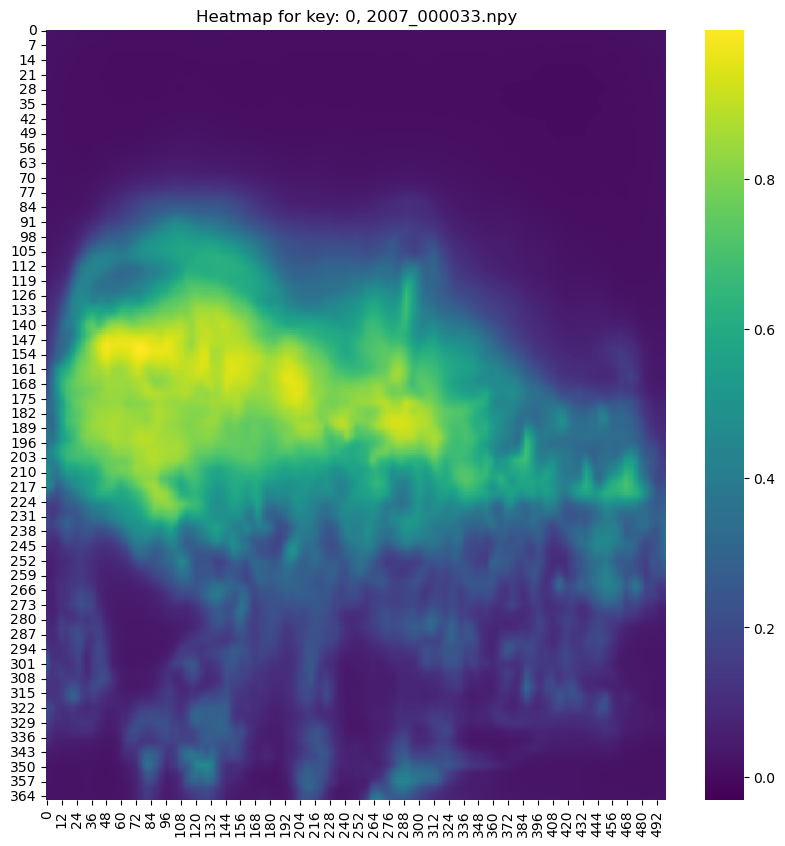

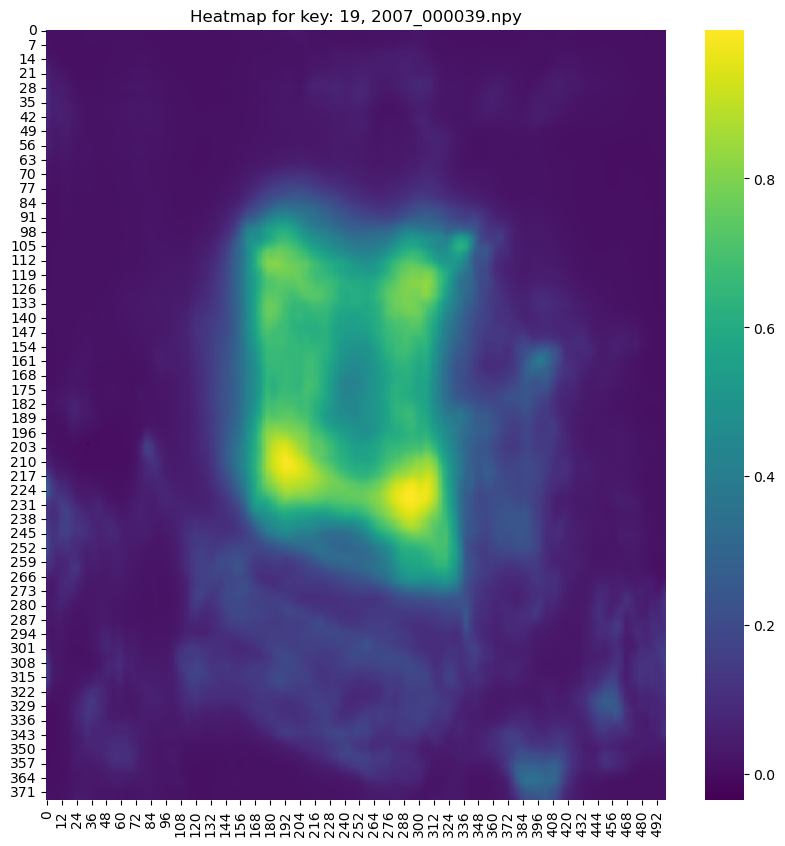

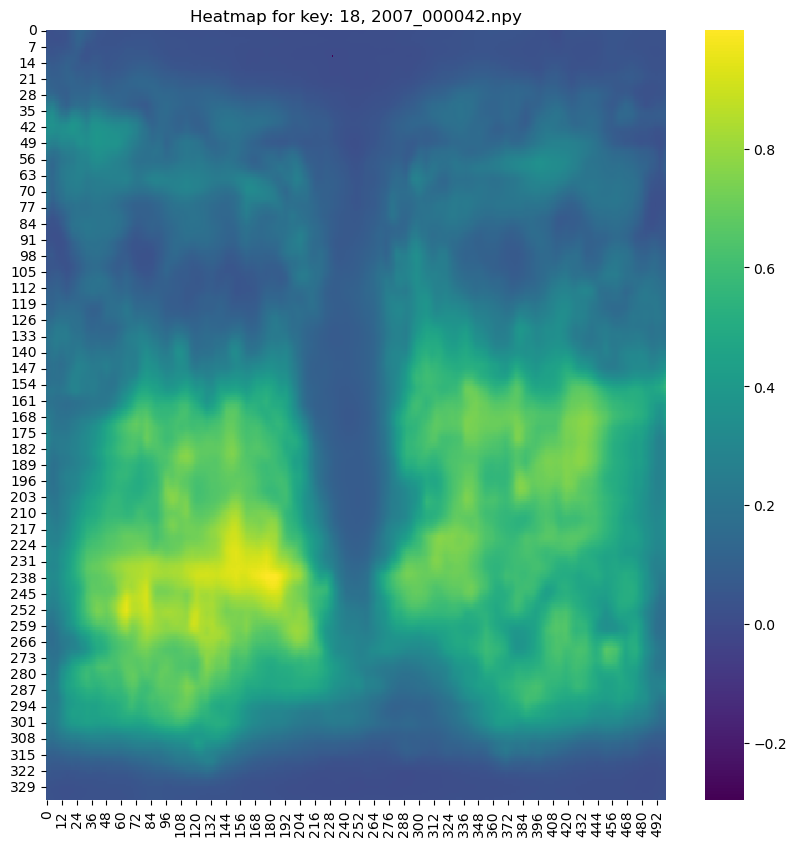

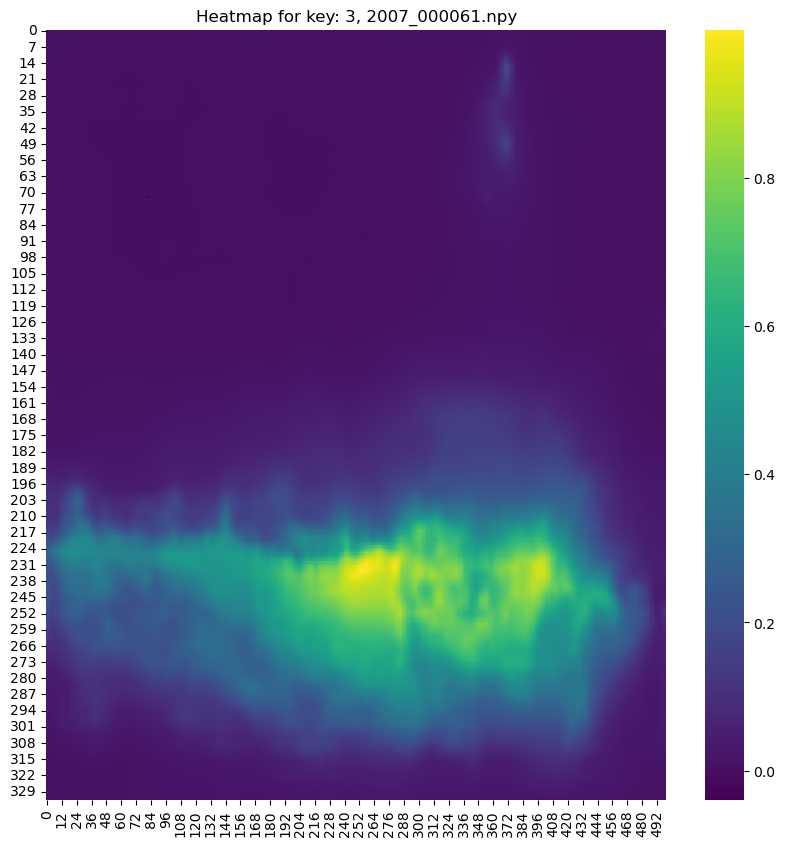

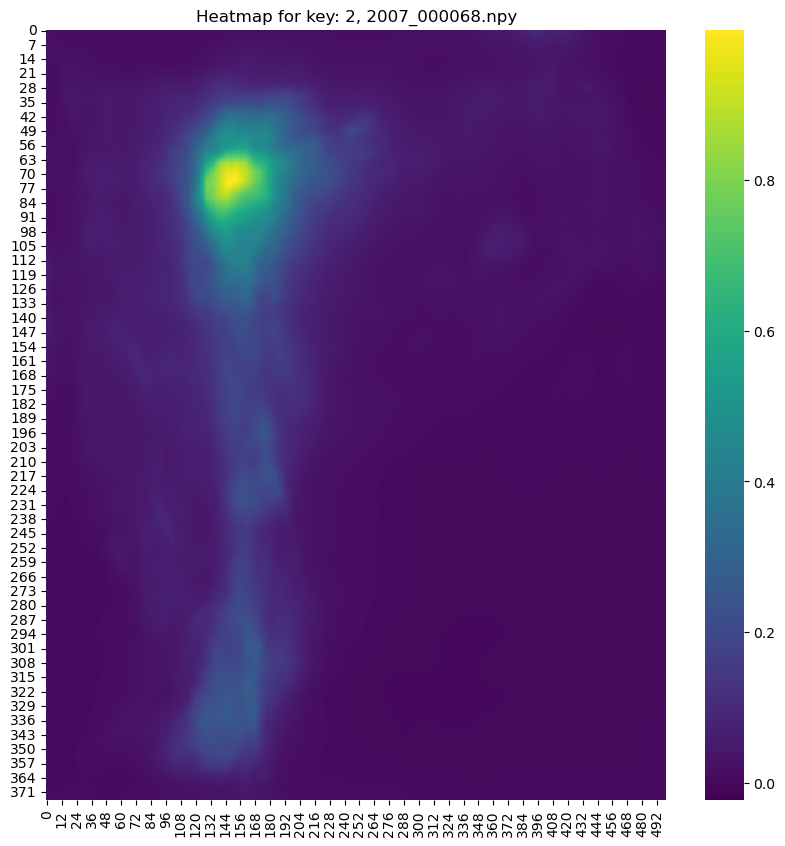

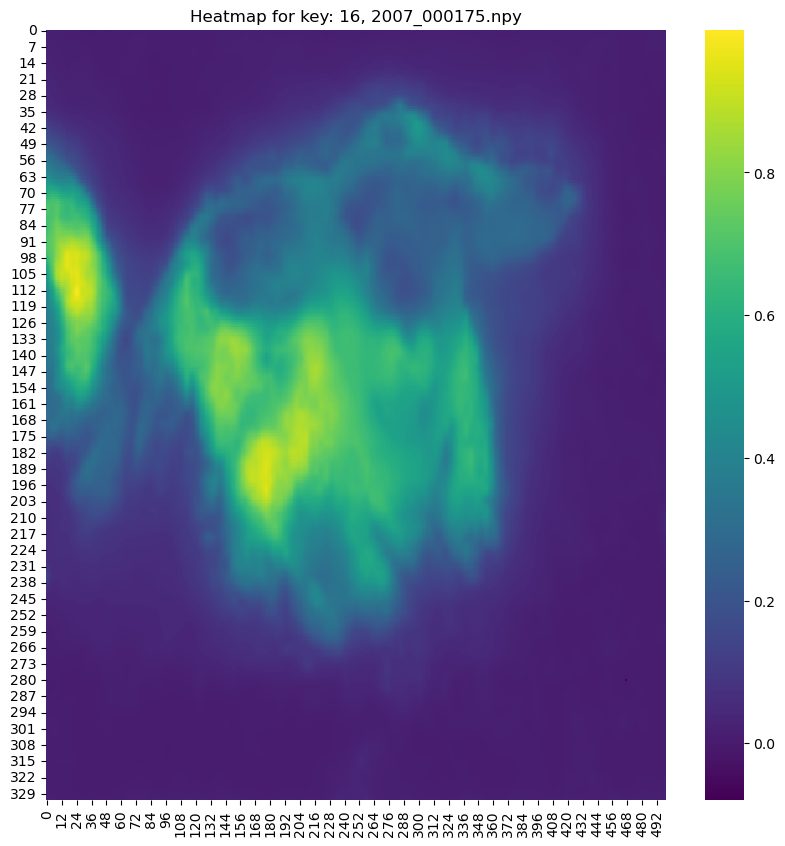

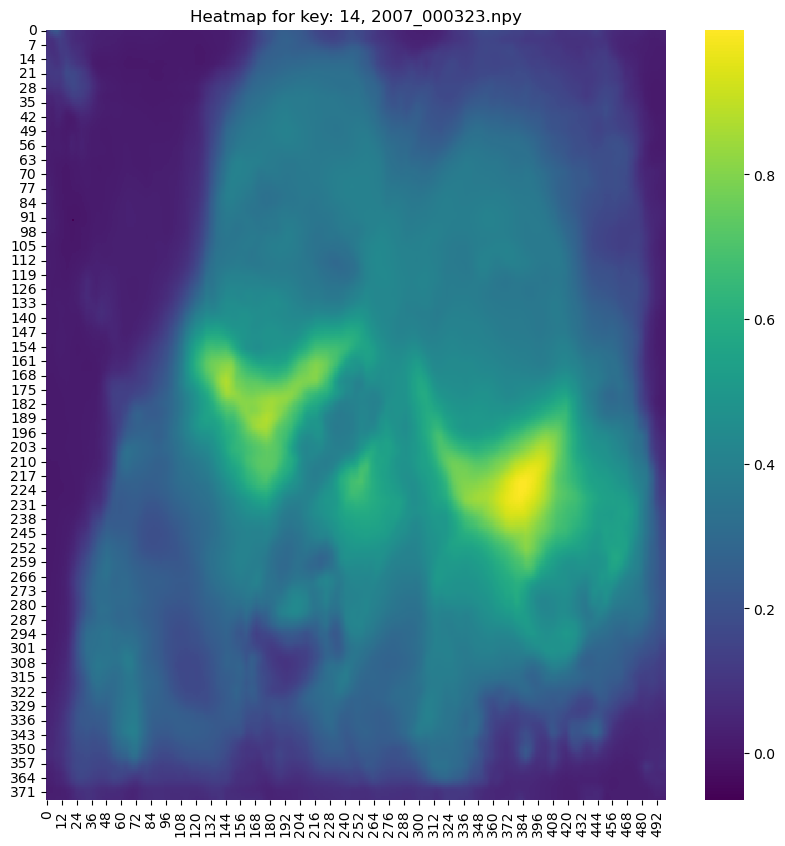

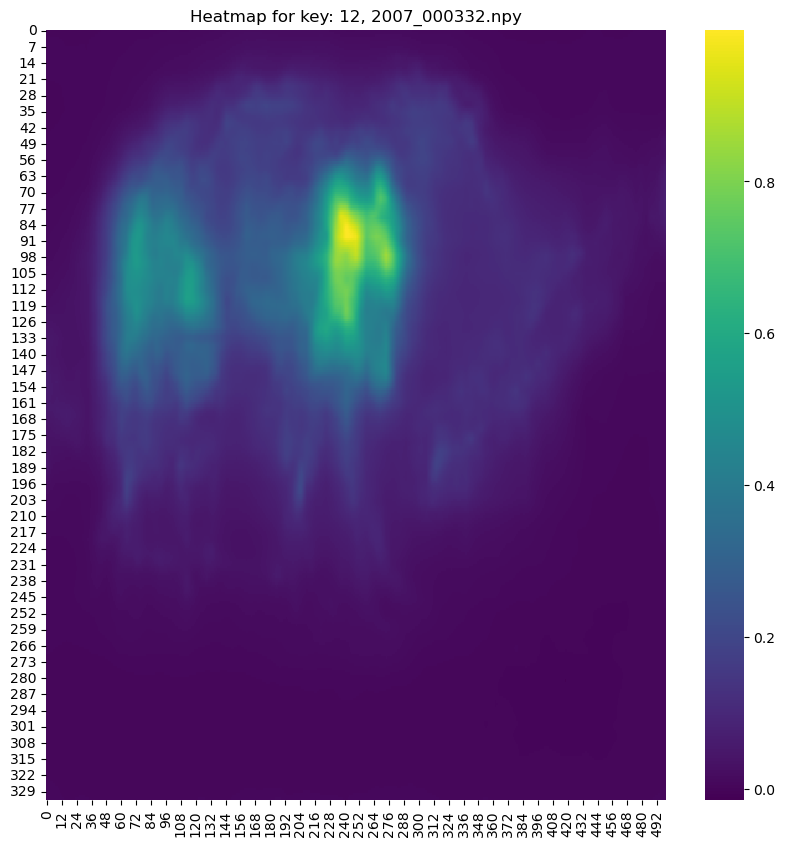

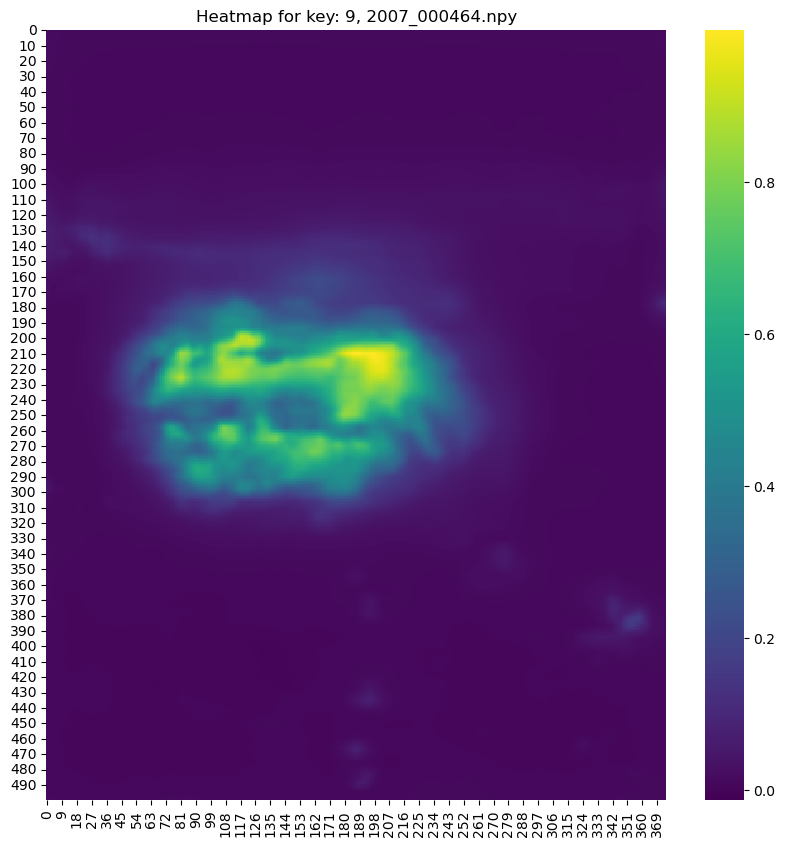

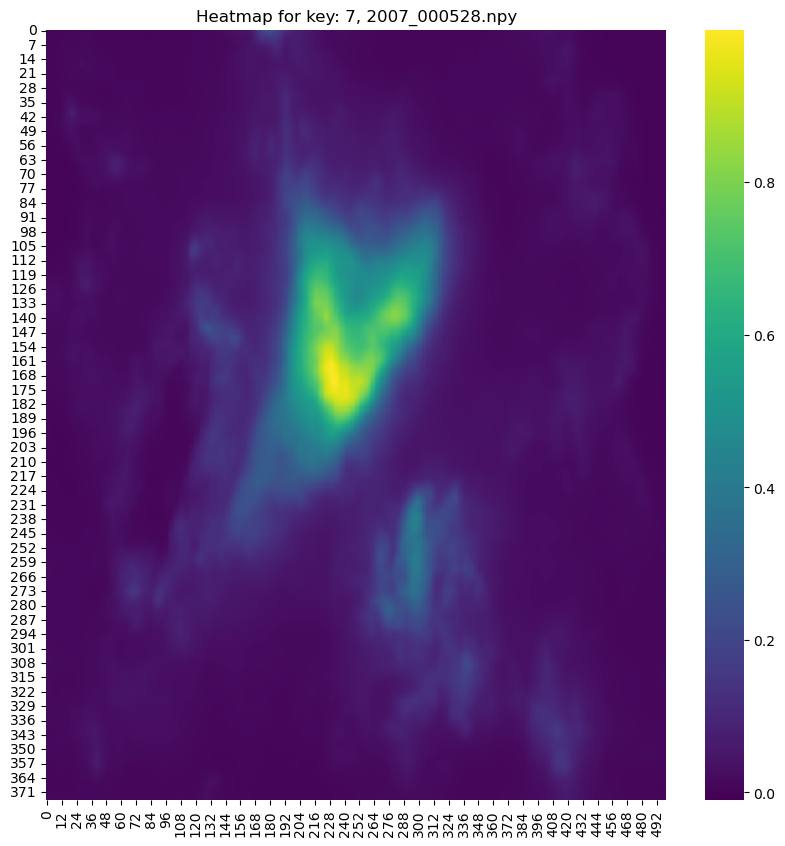

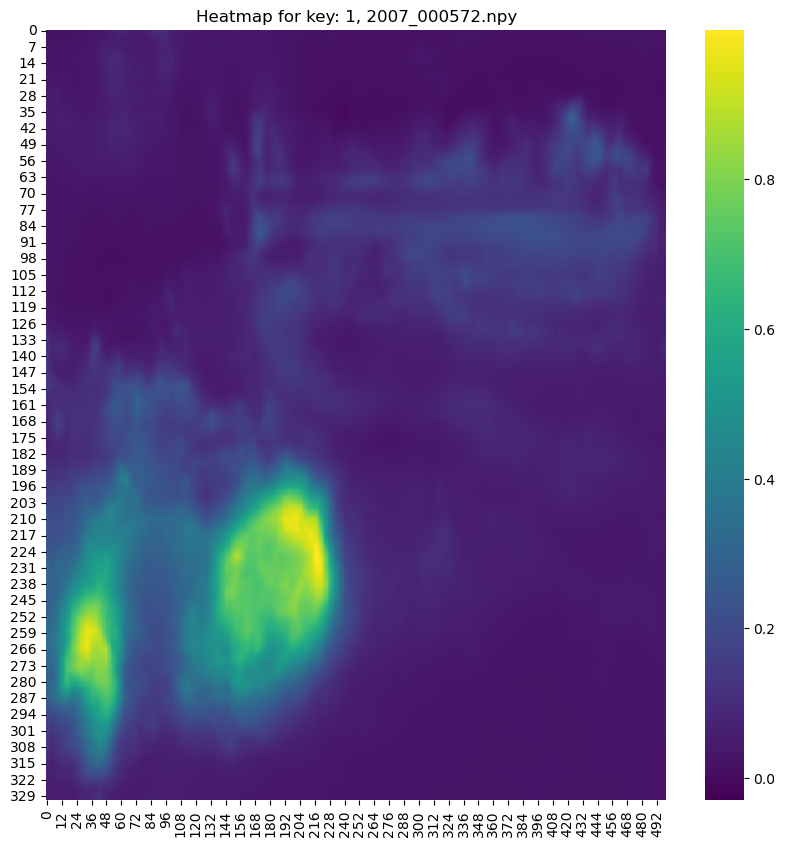

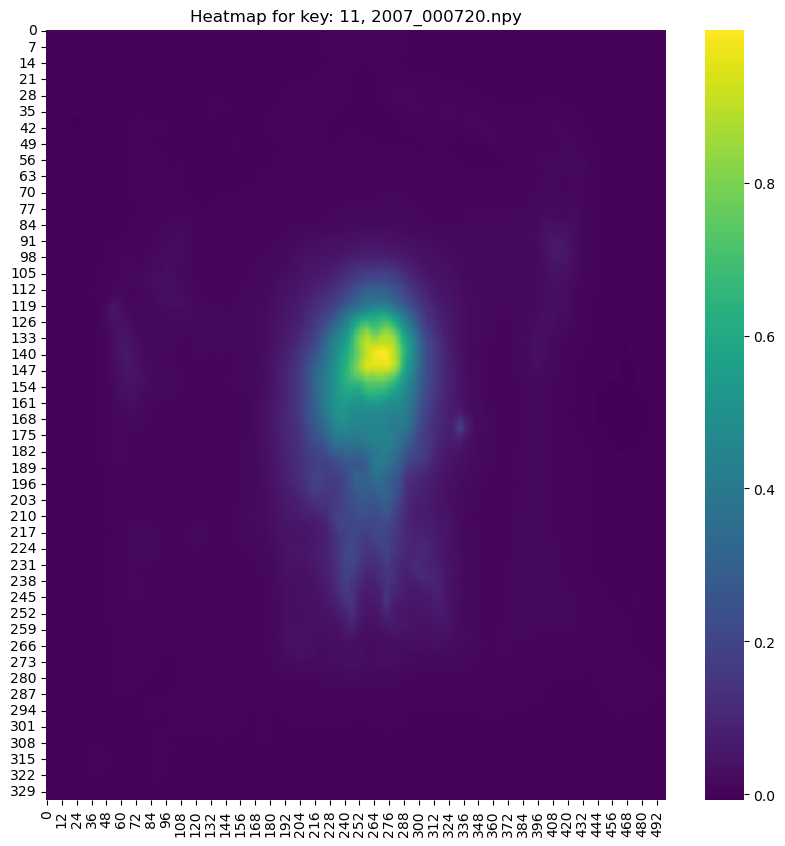

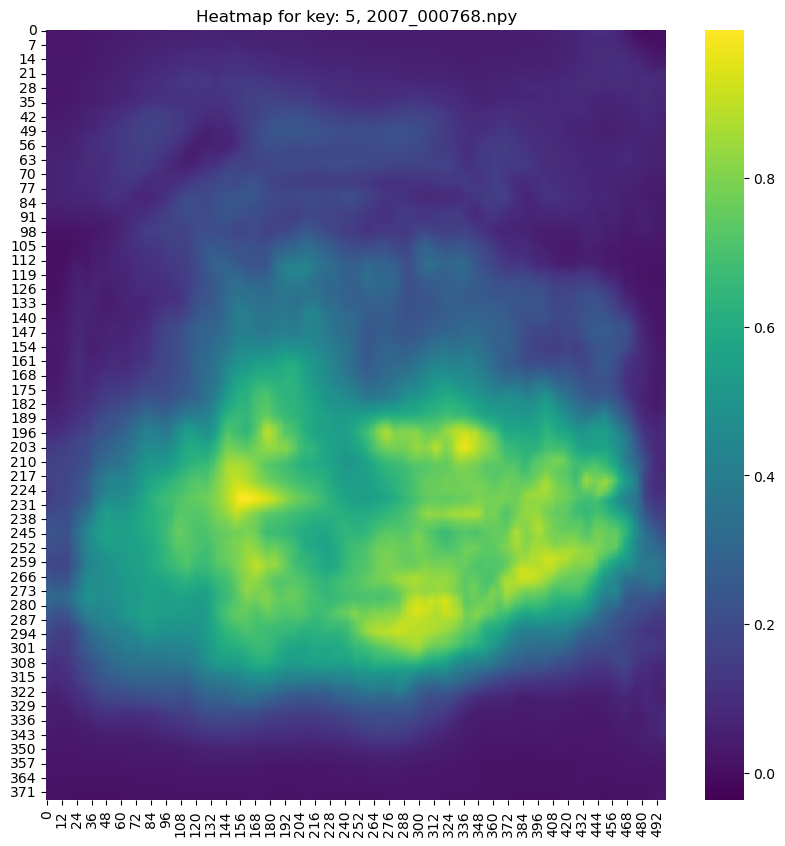

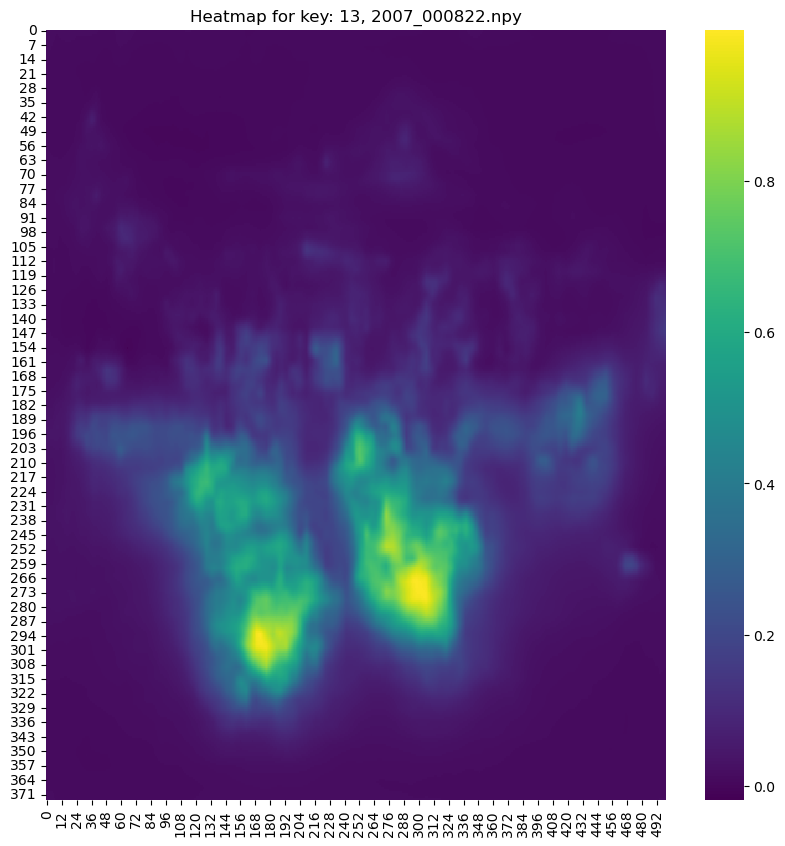

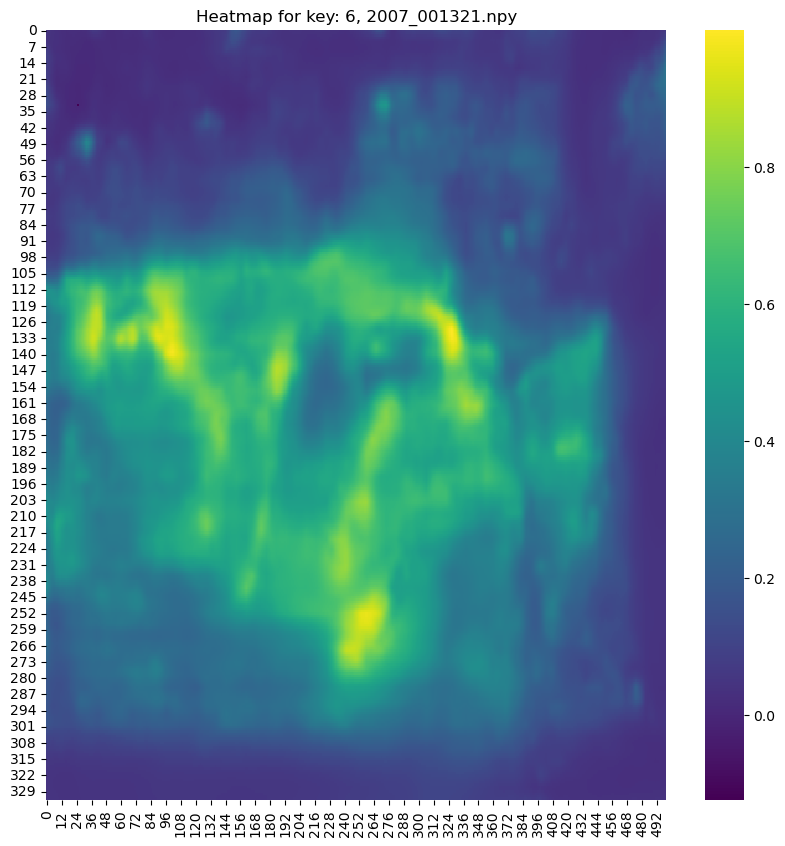

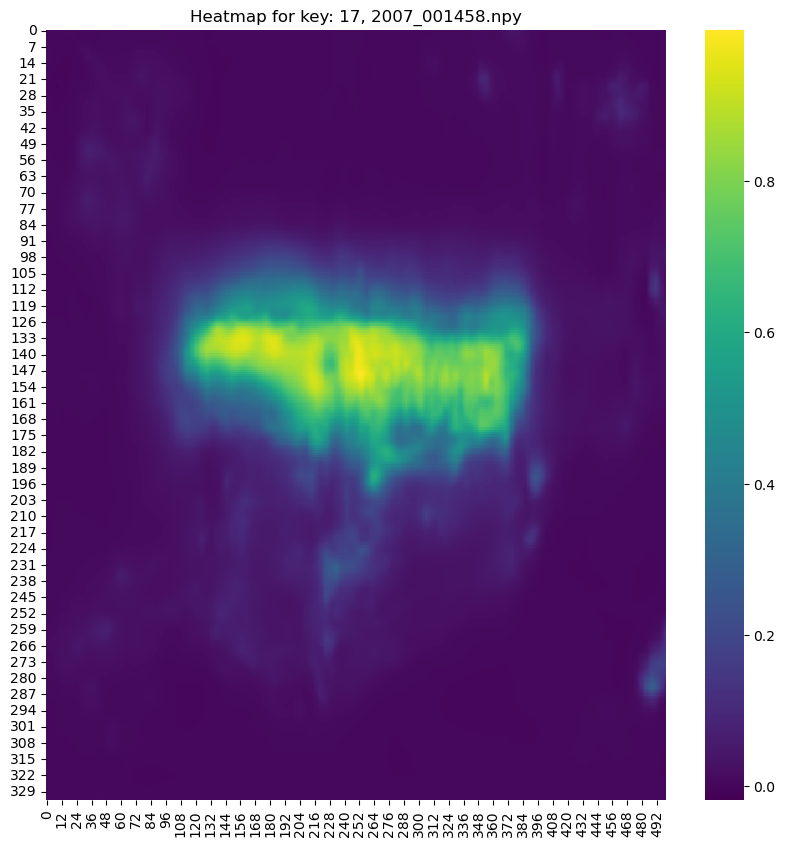

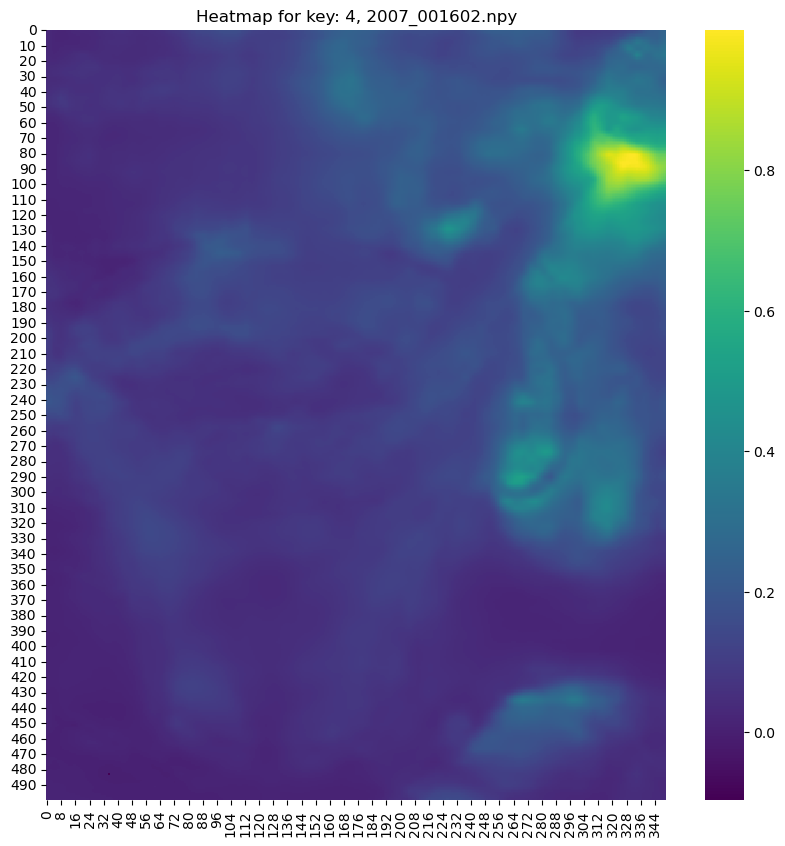

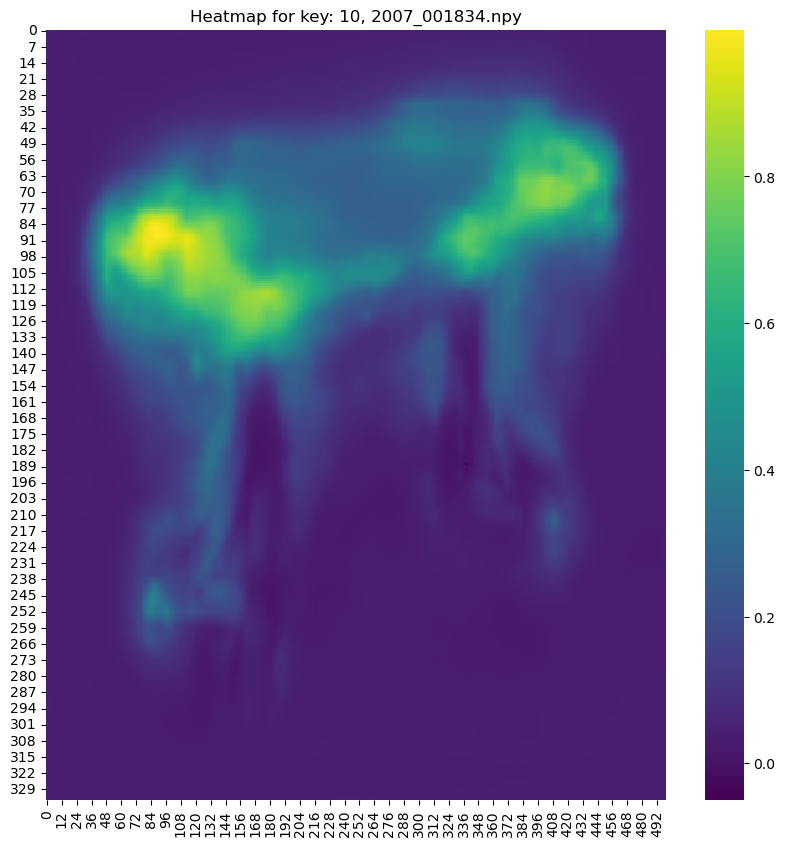

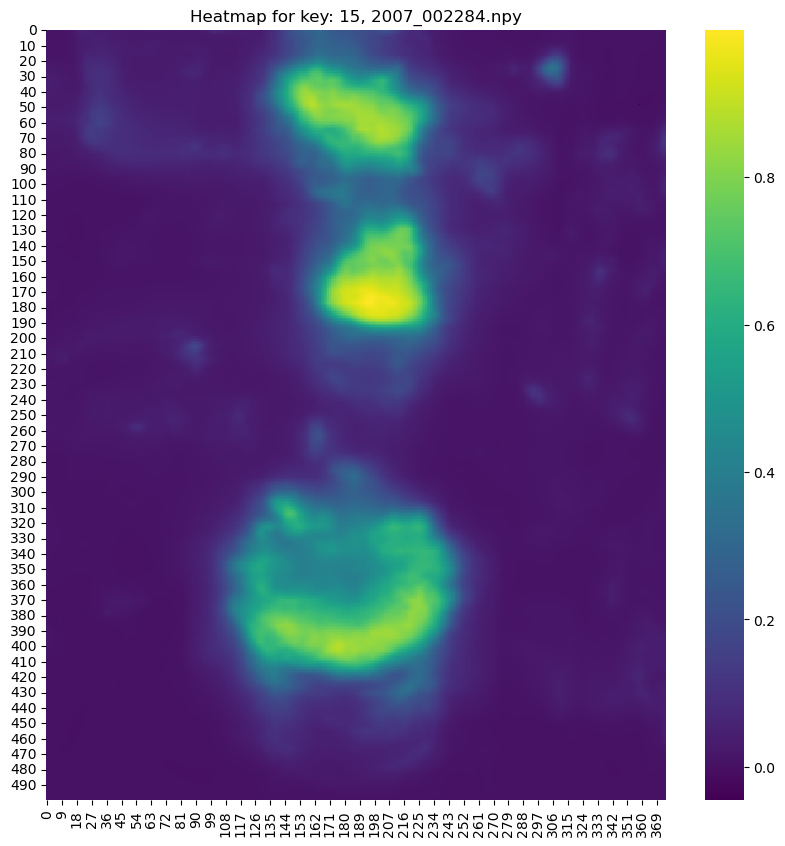

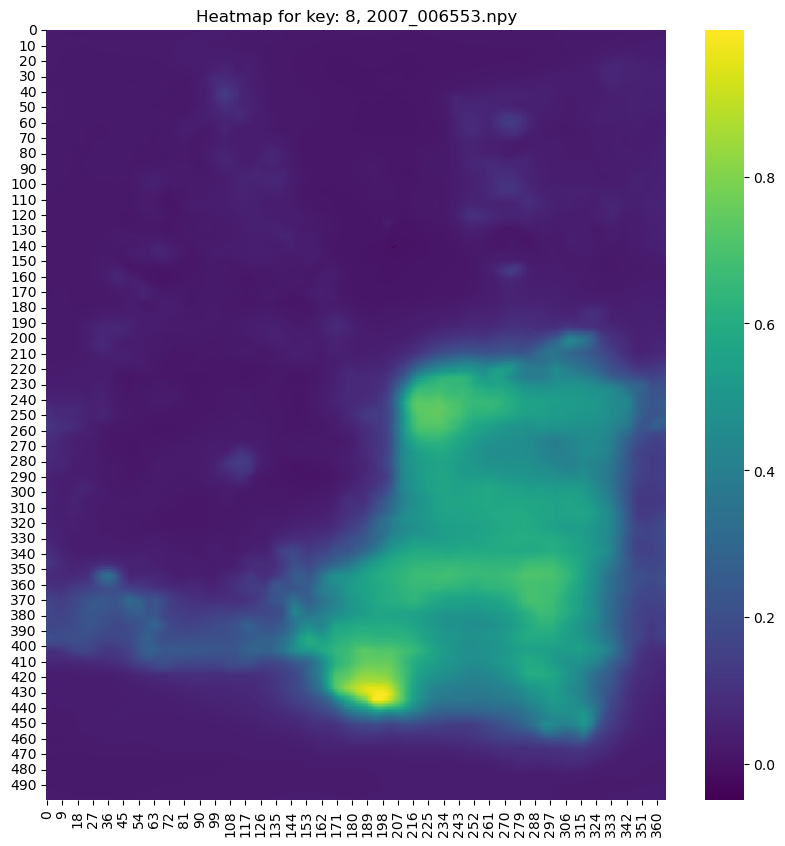

In [8]:
for key, filename in sample.items():
    file_path = os.path.join(out_cam_path, filename)
    data = np.load(file_path, allow_pickle=True).item()

    # Assuming the data is a 2D array suitable for a heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(data[key], cmap='viridis')
    plt.title(f'Heatmap for key: {key}, {filename}')
    plt.show()

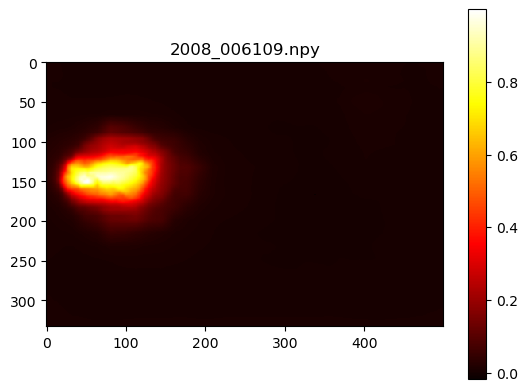

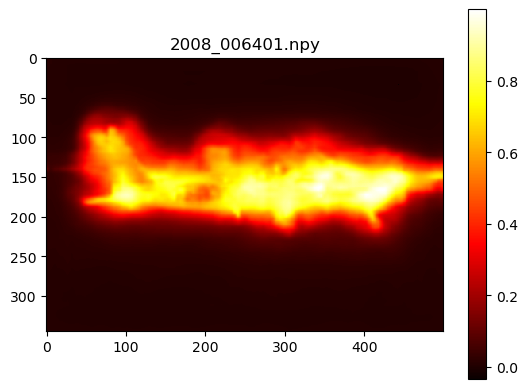

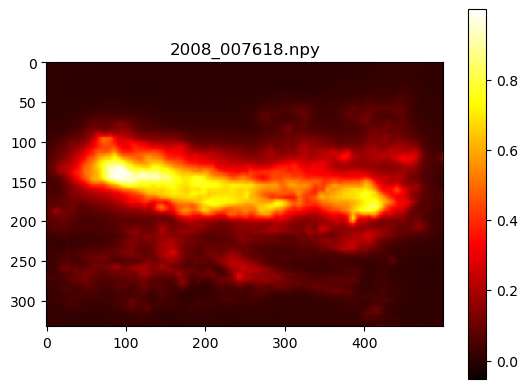

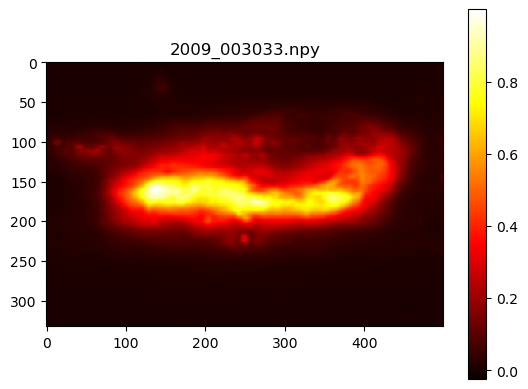

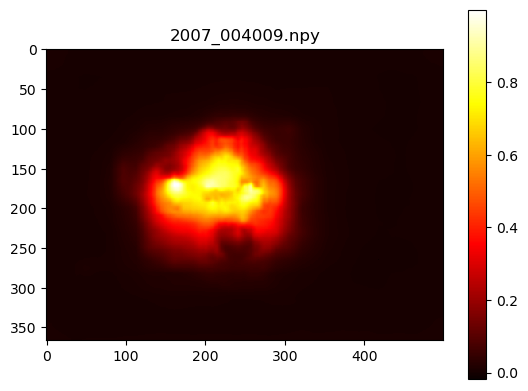

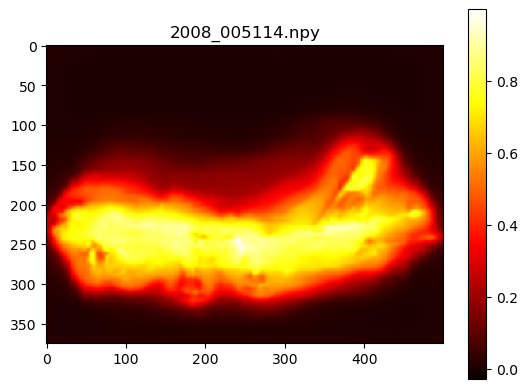

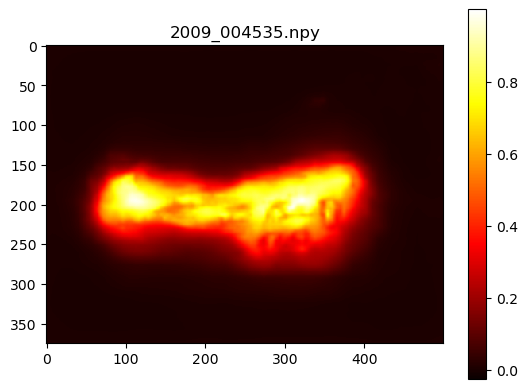

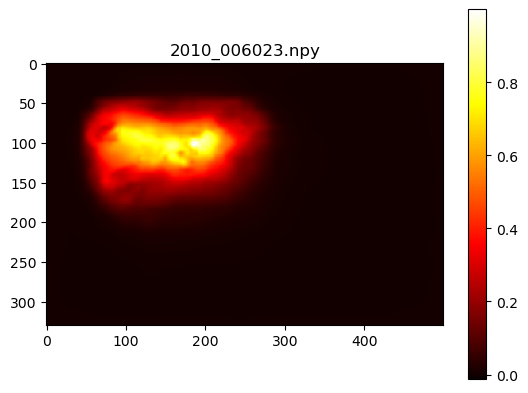

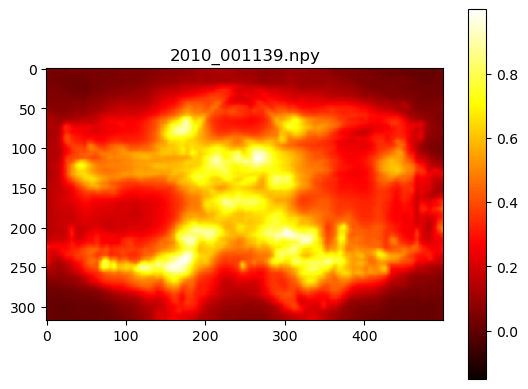

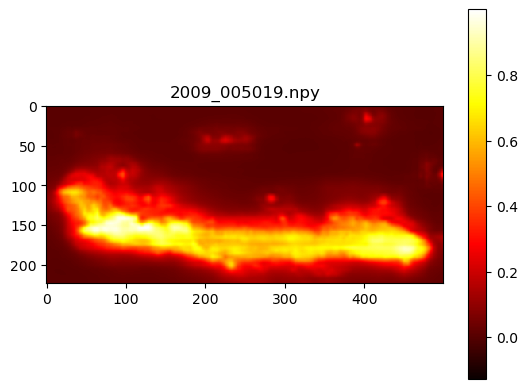

In [2]:
file_list_path = "C:/Users/snack/Desktop/CAM4SAM/temp_files/classZeroSingleInstanceImages.txt"

# Load the list of filenames
with open(file_list_path, "r") as file:
    file_names = file.readlines()

# Select 10 random filenames
selected_files = np.random.choice(file_names, 10, replace=False)

# Load and plot the heatmaps for the selected files
for file_name in selected_files:
    # Remove newline character from the end of the filename
    file_name = file_name.strip()
    
    # Load the .npy file
    file_path = os.path.join(out_cam_path, file_name)
    sample_npy_data = np.load(file_path, allow_pickle=True).item()

    # Extract the heatmap from the loaded data
    heatmap = sample_npy_data[0]  # Assuming the heatmap is stored at index 0

    # Plot the heatmap
    plt.figure()
    plt.imshow(heatmap, cmap='hot', interpolation='nearest')
    plt.title(file_name)
    plt.colorbar()  # Add colorbar to show the scale
    plt.show()

# Sobel operator for boundary detection

In [2]:
sample_zero_file = 'C:/Users/snack/Desktop/SEAM/VOC2012_data/JPEGImages/2007_002198.jpg'
sample_zero_image = cv2.imread(sample_zero_file)

file_path = os.path.join(out_cam_path, '2007_002198.npy')
sample_npy_data = np.load(file_path, allow_pickle=True).item()

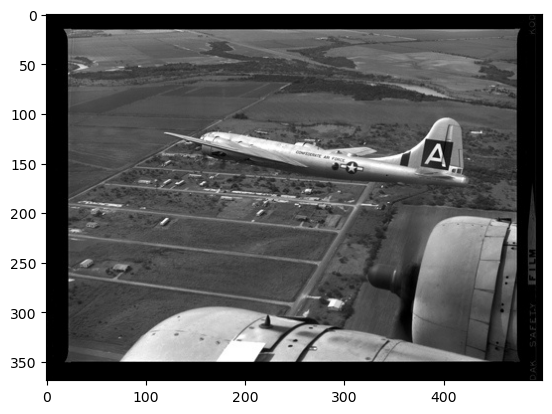

In [3]:
plt.imshow(sample_zero_image)

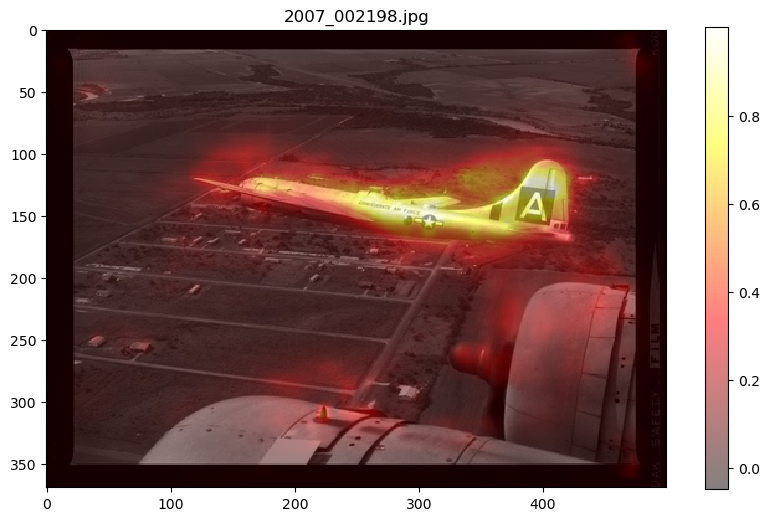

In [6]:
heatmap = sample_npy_data[0]

#threshold_value = 0.6
#thresholded_heatmap = np.where(heatmap > threshold_value, heatmap, 0)

plt.figure(figsize=(10, 6)) 

# Display the original image
plt.imshow(sample_zero_image, cmap='gray', interpolation='nearest')

# Overlay the thresholded heatmap
# 'alpha' controls the transparency of the overlay
plt.imshow(heatmap, cmap='hot', alpha=0.5, interpolation='nearest')

plt.title(sample_zero_file[-15:])
plt.colorbar()
plt.show()

In [7]:
#thresholded_heatmap = np.where(heatmap > threshold_value, heatmap, 0)

dx = ndimage.sobel(sample_npy_data[0], axis=0)
dy = ndimage.sobel(sample_npy_data[0], axis=1)
sobel_filtered_image = np.hypot(dx, dy)  # Equivalent to sqrt(dx^2 + dy^2)

sobel_filtered_image = sobel_filtered_image / np.max(sobel_filtered_image)

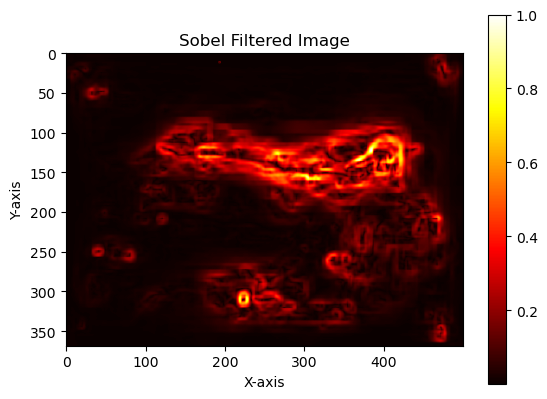

In [34]:
plt.imshow(sobel_filtered_image, cmap='hot')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Sobel Filtered Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

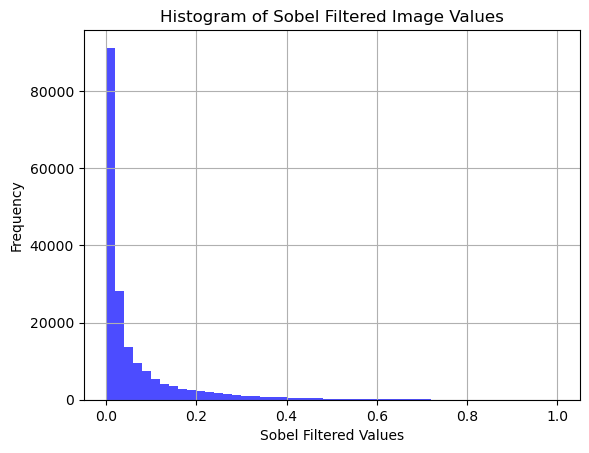

In [35]:
sobel_values = sobel_filtered_image.flatten()

# Plot histogram of sobel values
plt.hist(sobel_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Sobel Filtered Image Values')
plt.xlabel('Sobel Filtered Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [148]:
cam_threshold = 0.6
sobel_threshold = 0.7

points_of_interest = np.where((sample_npy_data[0] >= cam_threshold))

boundary_points = []

for point in zip(*points_of_interest):
    x, y = point

    sobel_value = sobel_filtered_image[x, y]
    
    if (sobel_value > sobel_threshold):
        
        boundary_points.append((y, x))

with open(os.path.join(output_dir, "points_of_interest.txt"), "w") as file:
    # Write the coordinates to the file
    for x, y in boundary_points:
        file.write(f"Point: ({x}, {y})\n")

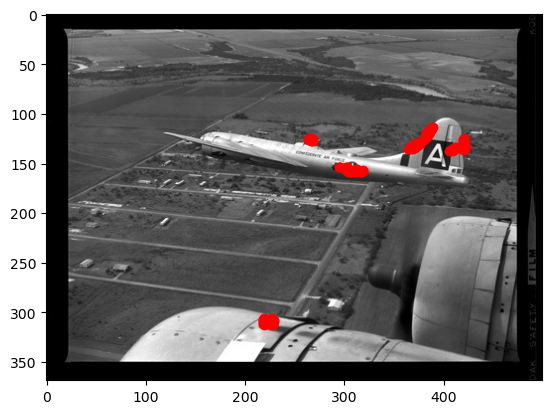

In [149]:
plt.imshow(sample_zero_image)  # Assuming you have loaded the original image
plt.scatter(*zip(*boundary_points), color='red', marker='o')  # Plotting the boundary points
plt.show()

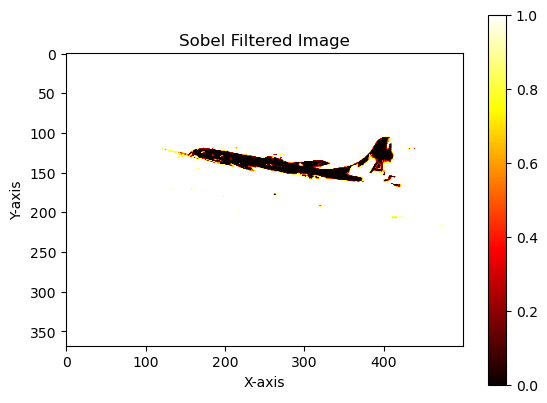

In [34]:
sample_npy_data = np.load("C:/Users/snack/Desktop/SEAM/voc12/out_crf_4.0/2007_002198.npy", allow_pickle=True).item()

heatmap = sample_npy_data[0]

threshold_value = 0.2
thresholded_heatmap = np.where(heatmap > threshold_value, heatmap, 0)

plt.imshow(thresholded_heatmap, cmap='hot')
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Sobel Filtered Image')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

In [154]:
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

def remove_outliers(points_array):
    data_array = np.array(points_array)
    mean = np.mean(data_array, axis=0)
    std_dev = np.std(data_array, axis=0)
    threshold = 1.8
    z_scores = np.abs((data_array - mean) / std_dev)
    filtered_data = data_array[(z_scores < threshold).all(axis=1)]
    
    return filtered_data

cam_threshold = 0.6
sobel_threshold = 0.6

points_of_interest = np.where((sample_npy_data[0] <= cam_threshold))
filtered_points_of_interest = remove_outliers(points_of_interest)

boundary_points = []

for point in zip(*filtered_points_of_interest):
    x, y = point

    sobel_value = sobel_filtered_image[x, y]
    
    if (sobel_value > sobel_threshold):
        
        boundary_points.append((y, x))
        #print(x,y)
    

#boundary_points_array = remove_outliers(boundary_points_array)
boundary_points_array = np.array(boundary_points)

# Apply DBSCAN clustering
eps = 10  # Adjust as needed, represents the maximum distance between two samples for them to be considered as in the same neighborhood
min_samples = 5  # Adjust as needed, represents the number of samples in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
cluster_labels = dbscan.fit_predict(boundary_points_array)

# Select one point from each cluster with even and maximum coverage
unique_labels = np.unique(cluster_labels)
selected_points = []
for label in unique_labels:
    cluster_points = boundary_points_array[cluster_labels == label]
    if len(cluster_points) > 0:
        # Calculate pairwise distances between cluster points
        distances = cdist(cluster_points, cluster_points)
        # Find the point with the maximum minimum distance to other points in the cluster
        min_distances = np.min(distances, axis=1)
        max_min_distance_idx = np.argmax(min_distances)
        selected_points.append(cluster_points[max_min_distance_idx])

selected_points = np.array(selected_points)


# Save the selected points to a new file
output_file_path = os.path.join(output_dir, "points_of_interest.txt")
np.savetxt(output_file_path, selected_points, fmt='%d', delimiter=',')

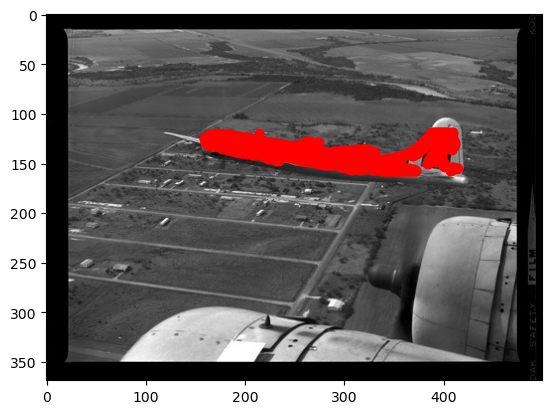

In [131]:
cam_threshold_second = 0.05
points_of_interest = np.where((sample_npy_data[0] <= cam_threshold))
boundary_points_2 = []

for point in zip(*points_of_interest):
    x, y = point
    boundary_points_2.append((y, x))

def remove_outliers(points_array):
    data_array = np.array(boundary_points_2)
    mean = np.mean(data_array, axis=0)
    std_dev = np.std(data_array, axis=0)
    threshold = 1.8
    z_scores = np.abs((data_array - mean) / std_dev)
    filtered_data = data_array[(z_scores < threshold).all(axis=1)]
    
    return filtered_data


filtered_data = remove_outliers(boundary_points_2)

plt.imshow(sample_zero_image) 
plt.scatter(*zip(*filtered_data), color='red', marker='o') 
plt.show()

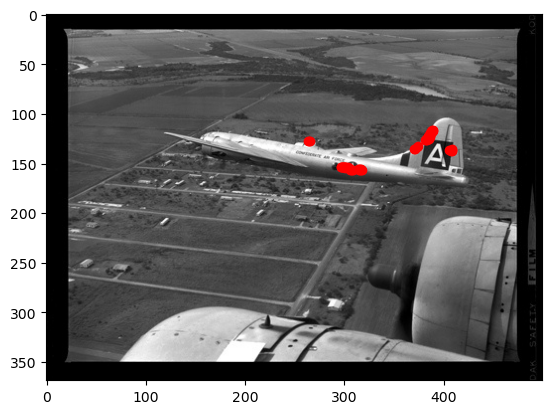

In [135]:
plt.imshow(sample_zero_image) 
plt.scatter(*zip(*boundary_points), color='red', marker='o') 
plt.show()

# Set up SAM

In [37]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [38]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [39]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "C:/Users/snack/Desktop/segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [40]:
image = cv2.cvtColor(sample_zero_image, cv2.COLOR_BGR2RGB)

In [41]:
predictor.set_image(image)

In [155]:
input_point_file_path = os.path.join(output_dir, "points_of_interest.txt")
input_points = np.loadtxt(input_point_file_path, delimiter=',')
if input_points.ndim == 1:
    input_points = input_points.reshape((1, -1))

#input_points = np.array([[384,193],[200,200]])

num_points = len(input_points)
input_labels = np.ones(num_points, dtype=int)
for i, point in enumerate(input_points):
    input_labels[i] = 1

print(input_points)

[[173. 119.]
 [393. 109.]
 [261. 127.]
 [411. 132.]
 [311. 135.]
 [257. 146.]
 [321. 146.]]


In [156]:
masks, _, _ = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=False,
)

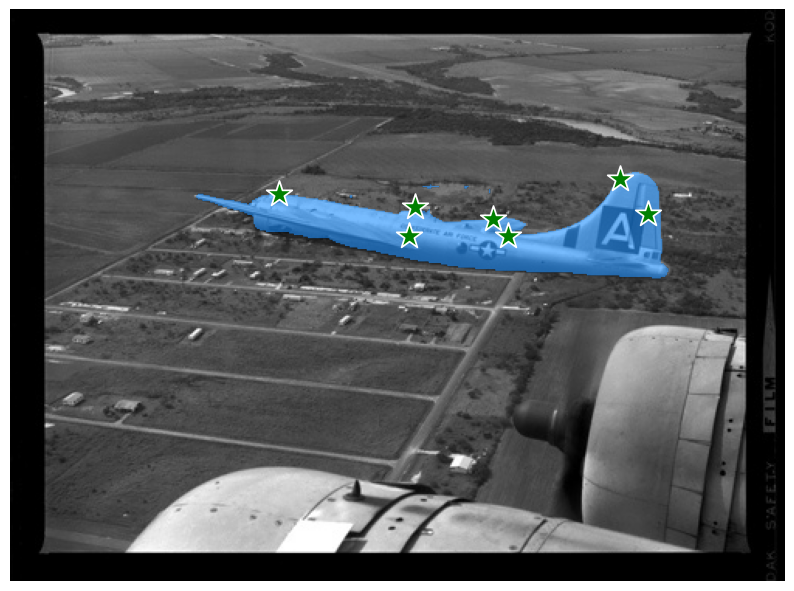

In [157]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_points(input_points, input_labels, plt.gca())
plt.axis('off')
plt.show()

# Comparing with the annotated ground truth

In [158]:
gt_mask = cv2.imread("C:/Users/snack/Desktop/SEAM/VOC2012_data/SegmentationClass/2007_002198.png", cv2.IMREAD_GRAYSCALE)
predicted_mask = masks

# Convert masks to boolean arrays
gt_mask_bool = gt_mask > 0
predicted_mask_bool = predicted_mask > 0

# Calculate intersection and union
intersection = np.logical_and(gt_mask_bool, predicted_mask_bool)
union = np.logical_or(gt_mask_bool, predicted_mask_bool)

# Compute IoU
iou = np.sum(intersection) / np.sum(union)
print("Intersection over Union (IoU):", iou)

Intersection over Union (IoU): 0.21777693004625434
